In [11]:
import numpy as np
import torch
import torch.nn as nn
from scipy.interpolate import interp1d
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from modules.data_utils import load_training_data


## 1. Feature map

### 1.1 Coarse grain

In [12]:
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def extract_stokes_arrays(xy: int, new_points: int = 112):
    # Original data
    nx = 480
    ny = 480

    stokes_array = np.load('../data/geom_height/080000_prof.npy').reshape(nx*ny, 300, 4)[xy]
    # Continuum calculation
    scaled_stokes = np.ones_like(stokes_array)

    # New spectral resolution arrays
    new_resol = np.linspace(0, 288, new_points, dtype=np.int64)
    new_resol = np.add(new_resol, 6)
    # Gaussian LSF kernel definition
    N_kernel_points = 13  # number of points of the kernel.
    def gauss(n: int = N_kernel_points, sigma: float = 1) -> np.ndarray:
        r = range(-int(n / 2), int(n / 2) + 1)
        return np.array([1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-float(x)**2 / (2 * sigma**2)) for x in r])
    g = gauss()

    # Convolution
    print("Degrading...")
    new_stokes = np.zeros((new_points, stokes_array.shape[-1]))

    for s in range(stokes_array.shape[-1]):
        spectrum = stokes_array[...,s]
        resampled_spectrum = np.zeros(new_points)
        i = 0
        for center_wl in new_resol:
            low_limit = center_wl - 6
            upper_limit = center_wl + 7

            if center_wl == 6:
                shorten_spect = spectrum[0:13]
            elif center_wl == 294:
                shorten_spect = spectrum[-14:-1]
            else:
                shorten_spect = spectrum[low_limit:upper_limit]

            resampled_spectrum[i] = np.sum(np.multiply(shorten_spect, g))
            i += 1
        new_stokes[:, s] = resampled_spectrum
        new_stokes[:, s] += 1e-4 * np.random.randn(new_points) * np.max(new_stokes[:, 0], axis=0)

    stokes_array = new_stokes
    # These are the new wavelength values for the degraded resolution
    new_wl = (new_resol * 0.01) + 6300.5


    # Continuum normalization
    scaled_stokes = np.ones_like(stokes_array)
    cont_indices = [0, 1, int(len(new_wl) / 2) - 1, int(len(new_wl) / 2), int(len(new_wl) / 2) + 1, -2, -1]
    wl_cont_values = new_wl[cont_indices]  # corresponding wavelength values to the selected continuum indices
    print("calculating the continuum...")
    for i in range(stokes_array.shape[-1]):
        cont_values = stokes_array[cont_indices, 0]  # corresponding intensity values to the selected continuum indices
        cont_model = interp1d(wl_cont_values, cont_values, kind="cubic")  # Interpolation applied over the assumed continuum values
        scaled_stokes[:, i] = stokes_array[:, i] / cont_model(new_wl)

    stokes_array = scaled_stokes

    # Weighting
    stokes_weigths = [1, 7, 7, 4]
    for i in range(len(stokes_weigths)):
        stokes_array[:, i] = stokes_array[:, i] * stokes_weigths[i]
    
    return stokes_array, new_wl

stokes_arrays = []
new_points = 112
for i in range(3):
    stokes_array, new_wl = extract_stokes_arrays(xy = i, new_points = new_points)
    stokes_arrays.append(stokes_array)
stokes_arrays = np.array(stokes_arrays)
    

Degrading...
calculating the continuum...
Degrading...
calculating the continuum...
Degrading...
calculating the continuum...


In [13]:
stokes_arrays.shape

(3, 112, 4)

In [14]:
# Putting channels in the right order (N, C, L)
stokes_arrays = np.moveaxis(stokes_arrays, 1, -1)
stokes_arrays = torch.tensor(stokes_arrays, dtype=torch.float32).to(device)

In [15]:
stokes_arrays.size()

torch.Size([3, 4, 112])

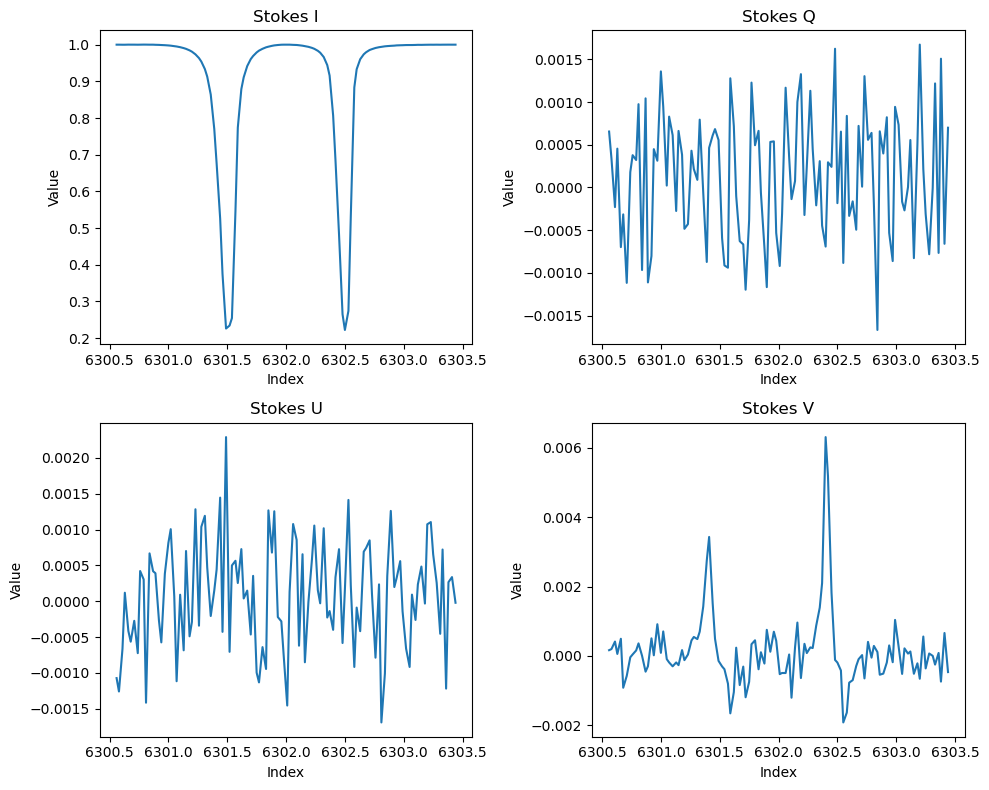

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(2*5, 2*4))

channels = ['I', 'Q', 'U', 'V']
for i in range(4):
    ax = axs[i//2, i%2]
    ax.plot(new_wl, stokes_arrays[0,i,:])
    ax.set_title(f'Stokes {channels[i]}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

In [59]:
scales = [1,2,4]

stokes_scales = {}
n_samples = stokes_arrays.size(0)
n_channels = stokes_arrays.size(1)

for s in scales:
    stokes_scales[f"{s}_scale"] = torch.zeros((n_samples, n_channels, new_points // s), dtype=torch.float32, device=device)

for sample in range(n_samples):
    for s in scales:
        for chan in range(len(channels)):
            for j in range(new_points // s):
                    stokes_scales[f"{s}_scale"][sample,chan,j] = torch.mean(stokes_arrays[sample,chan,j*s:(j+1)*s], dim=0)




In [60]:
stokes_arrays.size(2)

112

In [61]:
for s in scales:
    print(stokes_scales[f"{s}_scale"].size())

torch.Size([3, 4, 112])
torch.Size([3, 4, 56])
torch.Size([3, 4, 28])


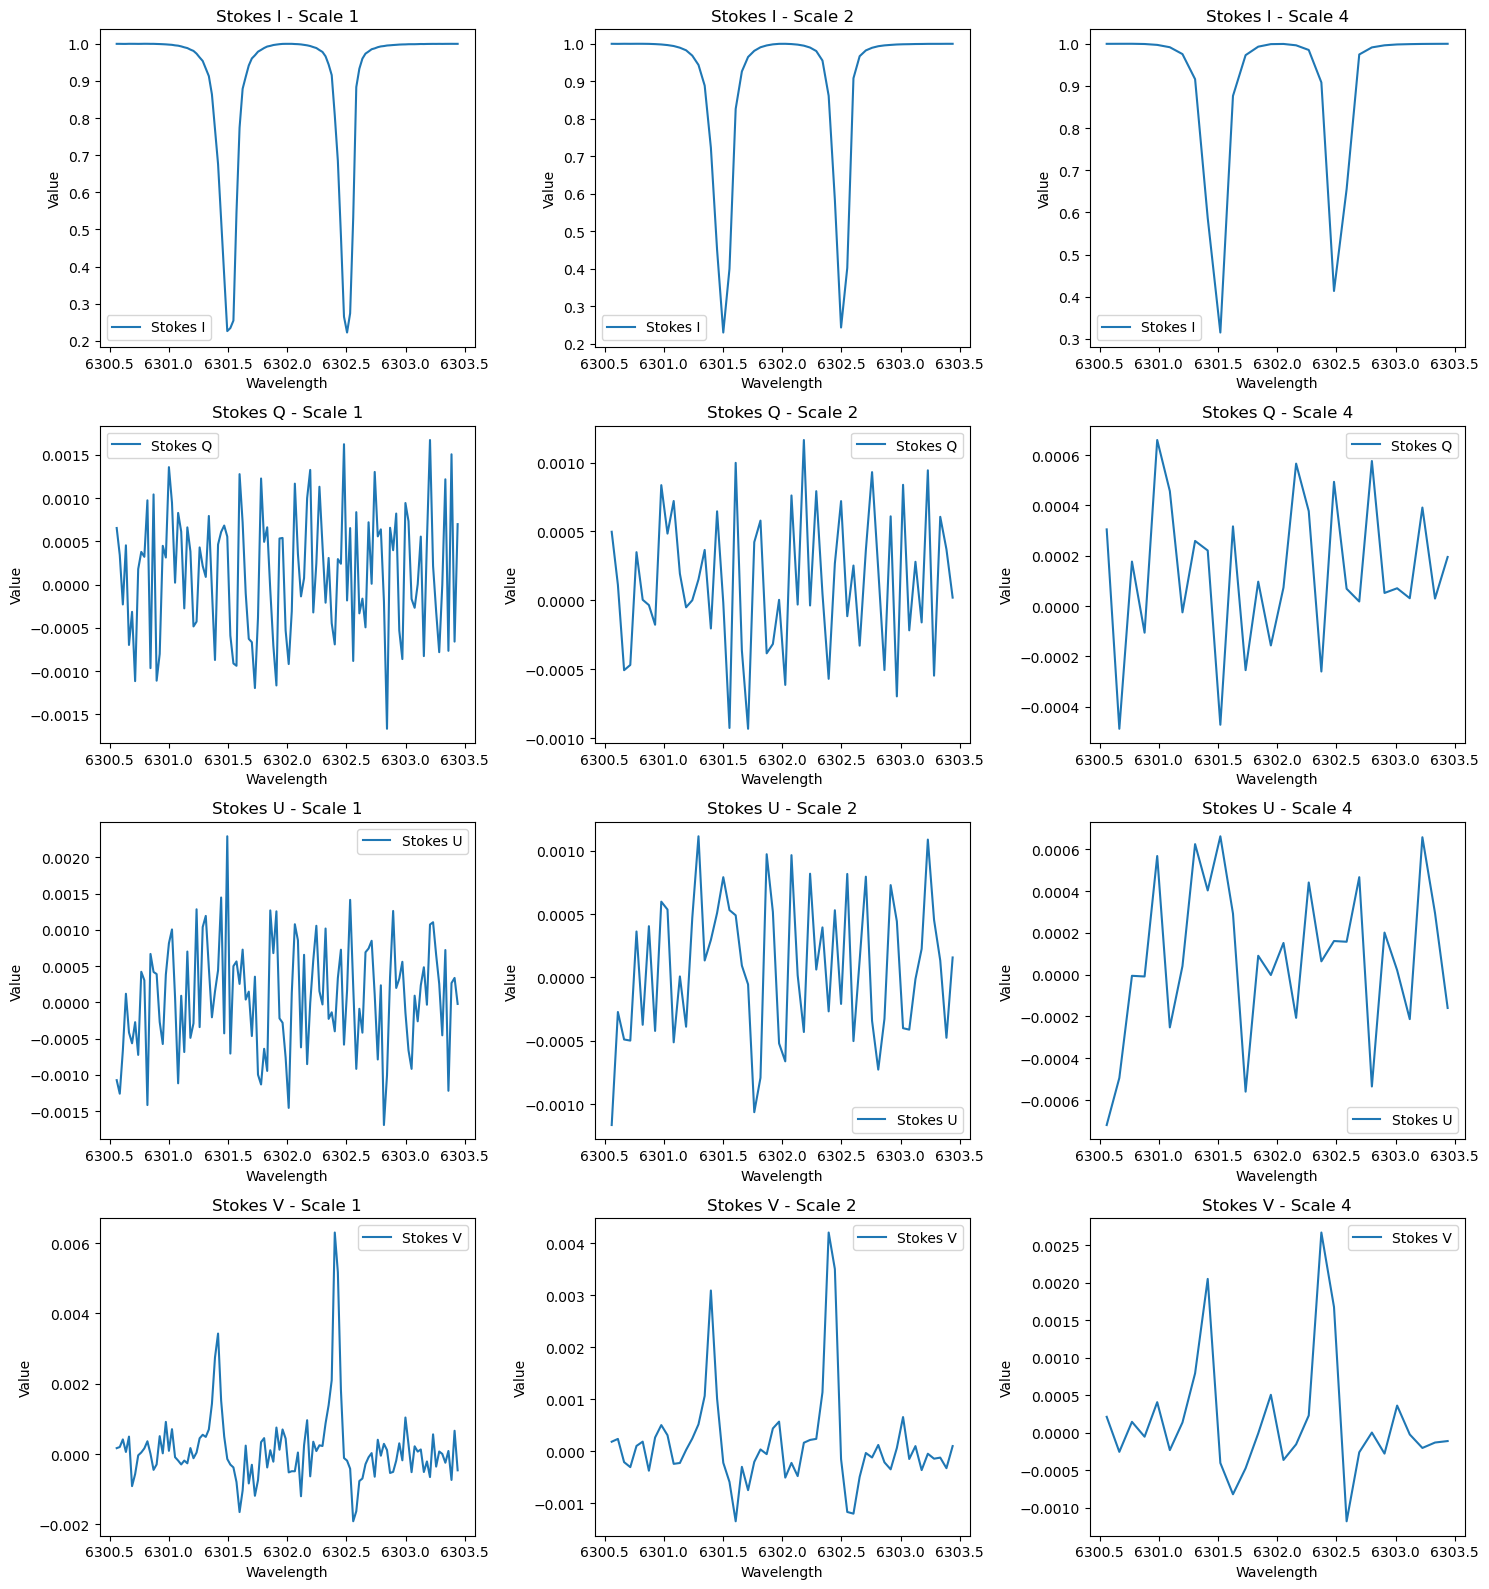

In [62]:
fig, axs = plt.subplots(4, len(scales), figsize=(len(scales)*5, 4*4))

for i in range(4):
    for idx, s in enumerate(scales):
        ax = axs[i, idx]
        ax.plot(np.linspace(new_wl[0], new_wl[-1], stokes_scales[f"{s}_scale"].shape[-1]), stokes_scales[f"{s}_scale"][0,i,:], label=f'Stokes {channels[i]}')
        ax.set_title(f'Stokes {channels[i]} - Scale {s}')
        ax.set_xlabel('Wavelength')
        ax.set_ylabel('Value')
        ax.legend()

plt.tight_layout()
plt.show()

Let's create a class for the coarse-grain operation to be a layer

In [63]:
class CoarseGrain(nn.Module):
    def __init__(self, scale: list[int]):
        super(CoarseGrain, self).__init__()
        self.scale = scale

    def forward(self, x):
        n_samples = x.size(0)
        n_channels = x.size(1)
        stokes_scale = torch.zeros((n_samples, n_channels, new_points // self.scale), dtype=torch.float32, device=device)
        for sample in range(x.size(0)):
            for chan in range(len(channels)):
                for j in range(new_points // self.scale):
                        stokes_scale[sample,chan,j] = torch.mean(x[sample,chan, j*s:(j+1)*s], dim=0)
        x = stokes_scale
        return x

In [64]:
# Create random input sizes
random_input_image = (1, 4, 114)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size


# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(CoarseGrain(2),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CoarseGrain (CoarseGrain)                [1, 4, 114]          [1, 4, 56]           --                   --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [66]:
stokes_scales = {}
for s in scales:
    coarse_grain_layer = CoarseGrain(scale = s).to(device)
    stokes_scales[f"{s}_scale"] = coarse_grain_layer(stokes_arrays)
    print(stokes_scales[f"{s}_scale"].size())

torch.Size([3, 4, 112])
torch.Size([3, 4, 56])
torch.Size([3, 4, 28])


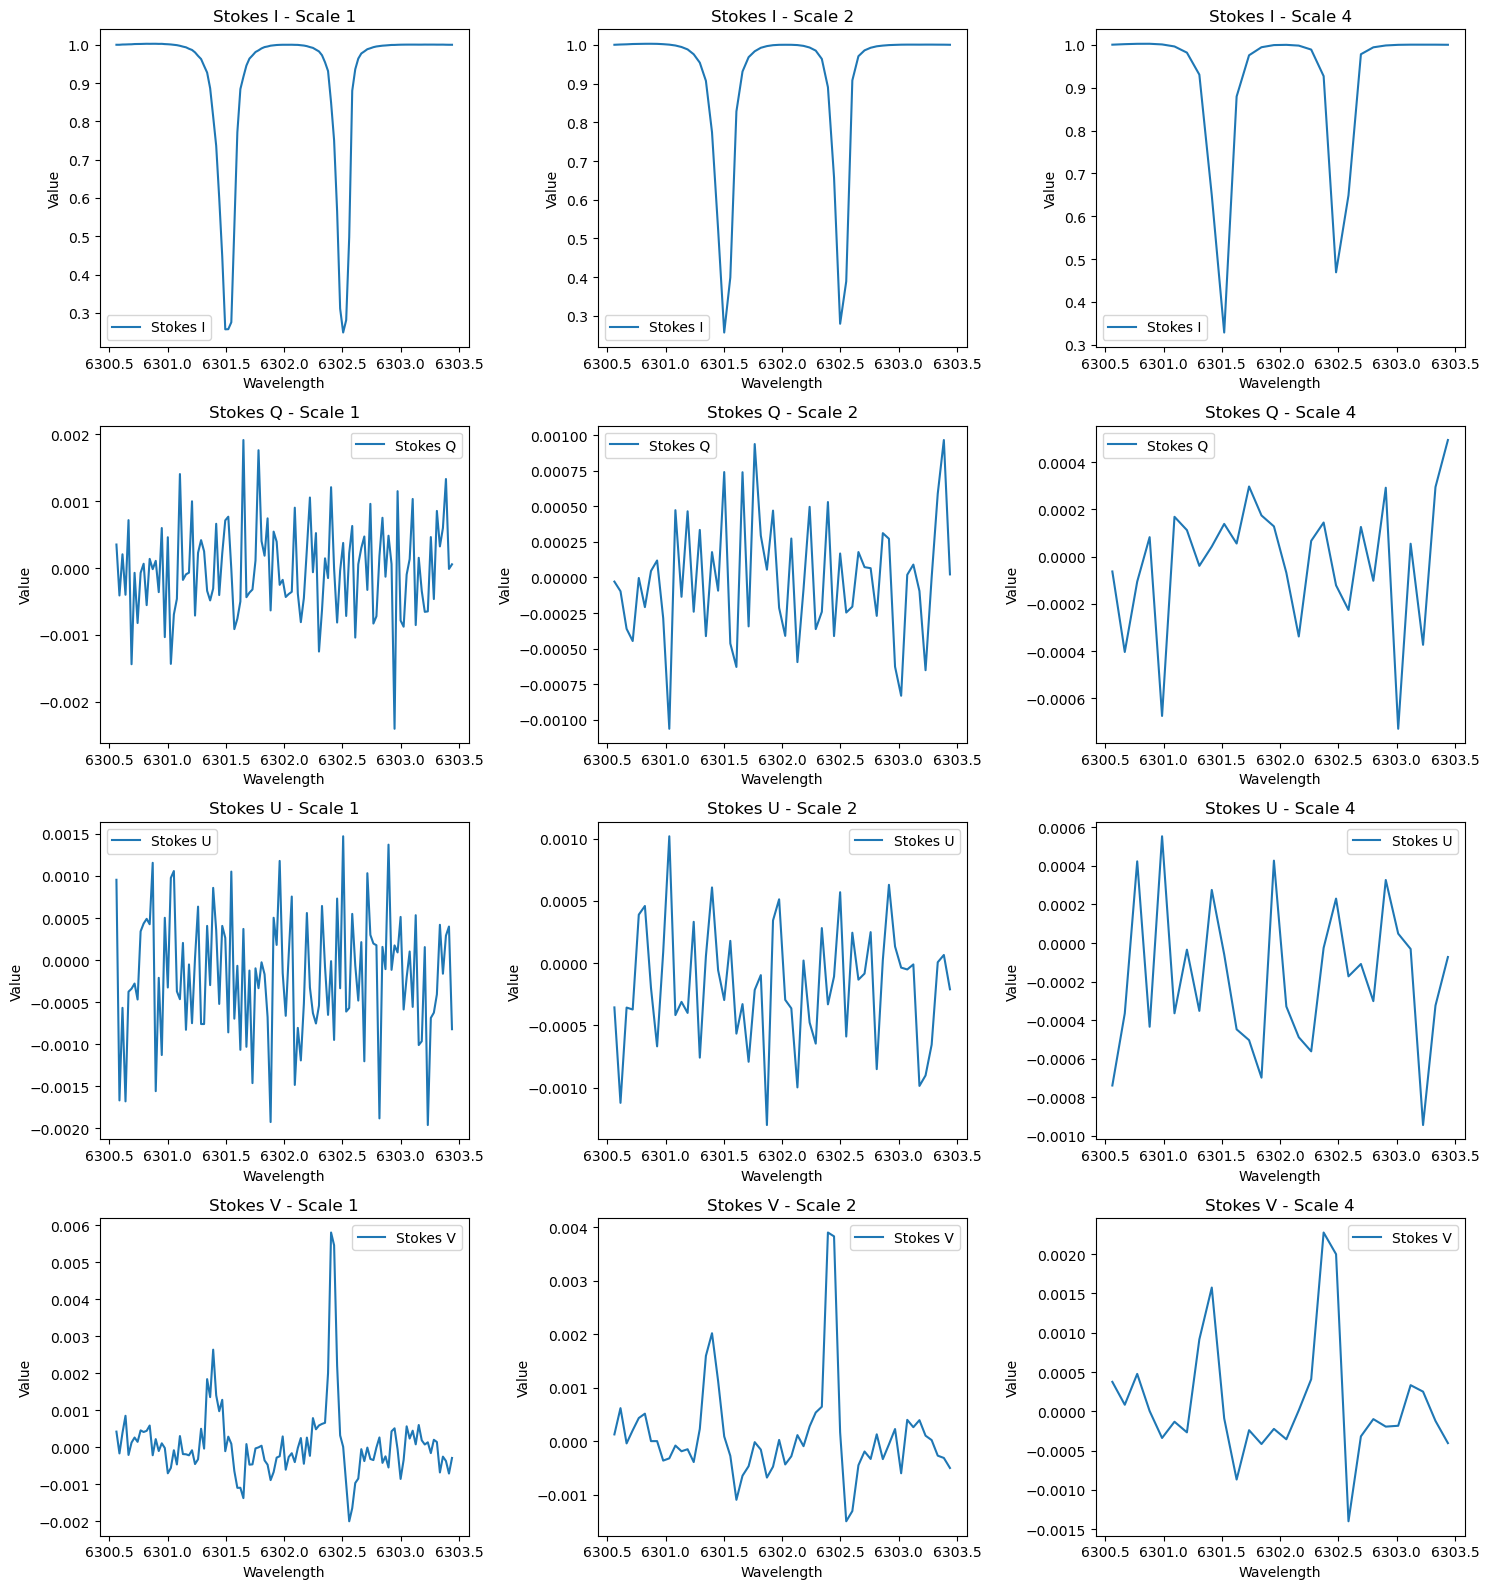

In [71]:
fig, axs = plt.subplots(4, len(scales), figsize=(len(scales)*5, 4*4))

for i in range(4):
    for idx, s in enumerate(scales):
        ax = axs[i, idx]
        ax.plot(np.linspace(new_wl[0], new_wl[-1], stokes_scales[f"{s}_scale"].shape[-1]), stokes_scales[f"{s}_scale"][1, i,:], label=f'Stokes {channels[i]}')
        ax.set_title(f'Stokes {channels[i]} - Scale {s}')
        ax.set_xlabel('Wavelength')
        ax.set_ylabel('Value')
        ax.legend()

plt.tight_layout()
plt.show()

### 1.2 Multiscale Feature Learning

We have that for each coarse-grained signal $\{y^{(s)}\}$

In [72]:
c1_filters = 16
c2_filters = 32
p = 2
conv_block1 = nn.Sequential(nn.Conv1d(in_channels = 4, out_channels=c1_filters, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool1d(kernel_size=p))
conv_block2 = nn.Sequential(nn.Conv1d(in_channels = c1_filters, out_channels=c2_filters, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool1d(kernel_size=p))

Let's try with $s = 4$

In [73]:
stokes_cg4 = stokes_scales[f"{4}_scale"]
stokes_cg4.size()

torch.Size([3, 4, 28])

In [74]:
conv1_output = conv_block1(stokes_cg4)
conv2_output = conv_block2(conv1_output)
conv1_output.size(), conv2_output.size()


(torch.Size([3, 16, 12]), torch.Size([3, 32, 4]))

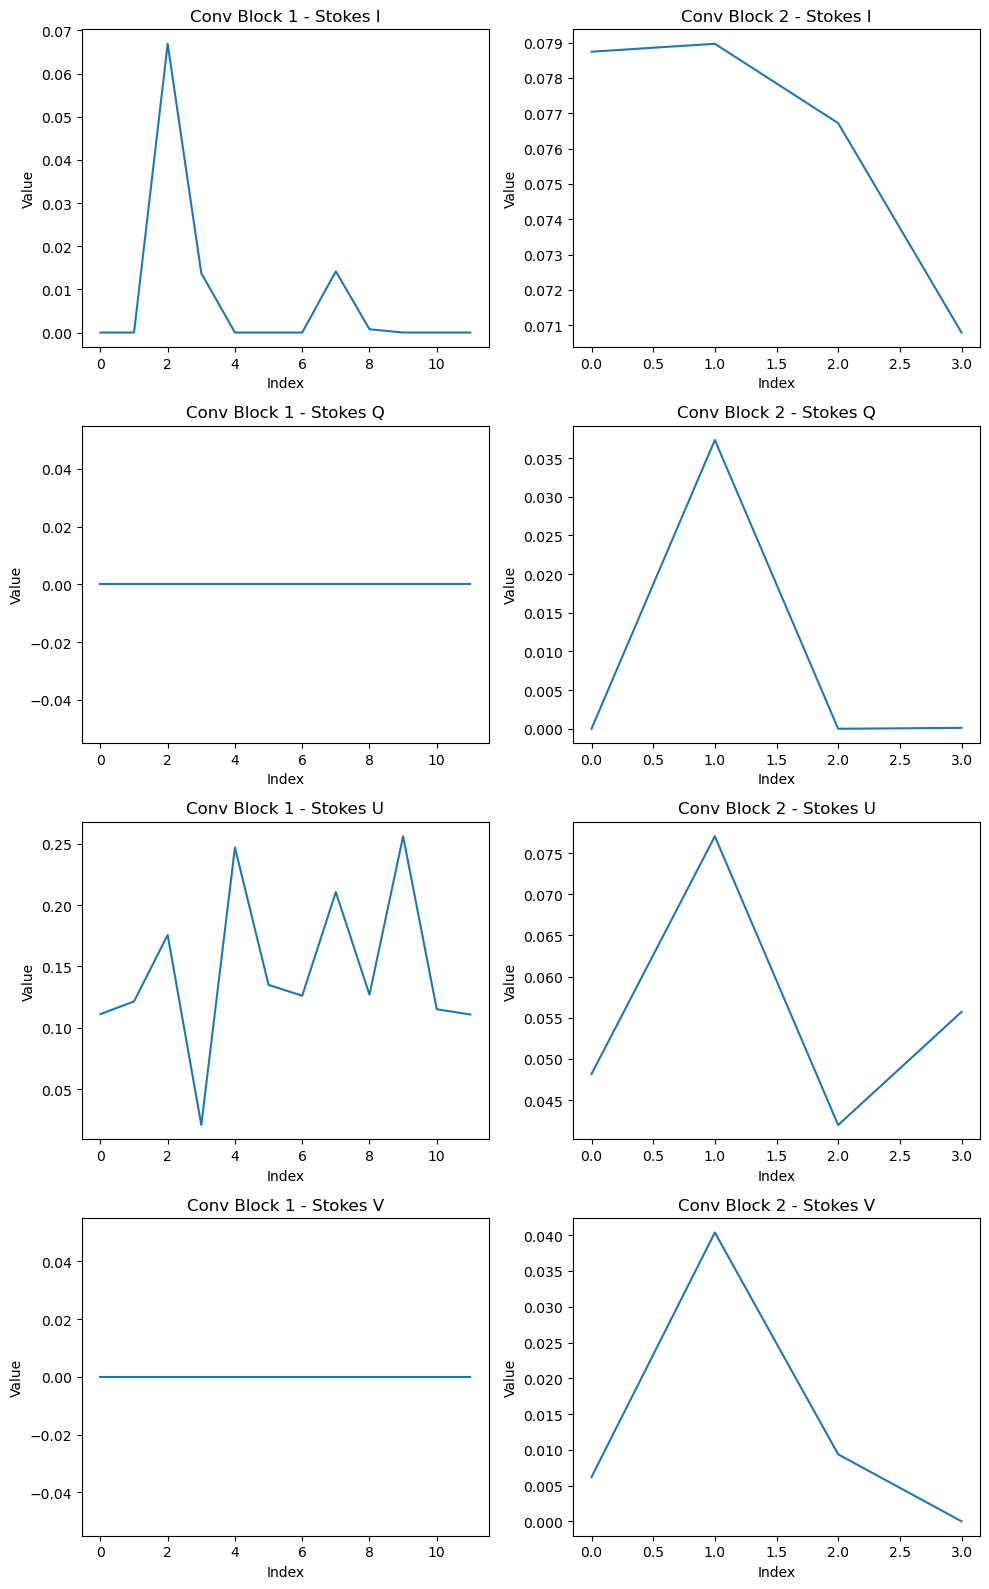

In [75]:
fig, axs = plt.subplots(4, 2, figsize=(2*5, 4*4))

for i in range(4):
    ax1 = axs[i, 0]
    ax1.plot(conv1_output[0, i].cpu().detach().numpy())
    ax1.set_title(f'Conv Block 1 - Stokes {channels[i]}')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Value')

    ax2 = axs[i, 1]
    ax2.plot(conv2_output[0, i].cpu().detach().numpy())
    ax2.set_title(f'Conv Block 2 - Stokes {channels[i]}')
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Value')

plt.tight_layout()
plt.show()

Let's create a class for condensing both layers

In [76]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int = 4, c1_filters: int = 16, c2_filters: int = 32, kernel_size: int = 5, stride: int = 1, padding: int = 0, pool_size: int = 2):
        super(ConvBlock, self).__init__()
        self.c1 = nn.Sequential(nn.Conv1d(in_channels = in_channels, out_channels=c1_filters, kernel_size=kernel_size, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool1d(kernel_size=p))
        self.c2 = nn.Sequential(nn.Conv1d(in_channels = c1_filters, out_channels=c2_filters, kernel_size=kernel_size, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool1d(kernel_size=pool_size))

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        return x

Let's test it

In [77]:
for s in scales:
    stokes_cg = stokes_scales[f"{s}_scale"]
    conv_block = ConvBlock(in_channels=4, c1_filters=16, c2_filters=32, kernel_size=5, stride=1, padding=0, pool_size=2).to(device)
    conv_block_output = conv_block(stokes_cg)
    print(conv_block_output.size())

torch.Size([3, 32, 25])
torch.Size([3, 32, 11])
torch.Size([3, 32, 4])


### 1.3 Coarse-grain-cnn1d integraction

Let's create a class that integrates the coarse-grain operation and the cnn1d feature mapping to create our multiscale feature maps for the following part related to the densely connected layers

In [80]:
class MultiScaleFeatureMapping(nn.Module):
    def __init__(self, scales: list[int], in_channels: int = 4, c1_filters: int = 16, c2_filters: int = 32, kernel_size: int = 5, stride: int = 1, padding: int = 0, pool_size: int = 2):
        super(MultiScaleFeatureMapping, self).__init__()
        self.scales = scales
        self.coarse_grains = nn.ModuleDict({})
        for s in scales:
            self.coarse_grains[f"scale_{s}"] = CoarseGrain(scale = s)
        self.conv_block = ConvBlock(in_channels=4, c1_filters=c1_filters, c2_filters=c2_filters, kernel_size=kernel_size, stride=stride, padding=padding, pool_size=pool_size)
    def forward(self, x):
        feature_maps = []
        for s in scales:
            x = self.coarse_grains[f"scale_{s}"](x)
            feature_maps.append(self.conv_block(x))
        x = torch.concat(feature_maps, dim=-1)
        return x
        

In [81]:
# Create random input sizes
random_input_image = (1, 4, 112)


# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(MultiScaleFeatureMapping(scales = scales),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
MultiScaleFeatureMapping (MultiScaleFeatureMapping)     [1, 4, 112]          [1, 32, 40]          --                   True
├─ModuleDict (coarse_grains)                            --                   --                   --                   --
│    └─CoarseGrain (scale_1)                            [1, 4, 112]          [1, 4, 112]          --                   --
├─ConvBlock (conv_block)                                [1, 4, 112]          [1, 32, 25]          --                   True
│    └─Sequential (c1)                                  [1, 4, 112]          [1, 16, 54]          --                   True
│    │    └─Conv1d (0)                                  [1, 4, 112]          [1, 16, 108]         336                  True
│    │    └─ReLU (1)                                    [1, 16, 108]         [1, 16, 108]         --                   --
│    │   

Visualize!!

In [82]:
multi_scale_feature_mapping = MultiScaleFeatureMapping(scales = scales).to(device)
multi_scale_feature_mapping_output = multi_scale_feature_mapping(stokes_arrays)

torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])
torch.Size([40])


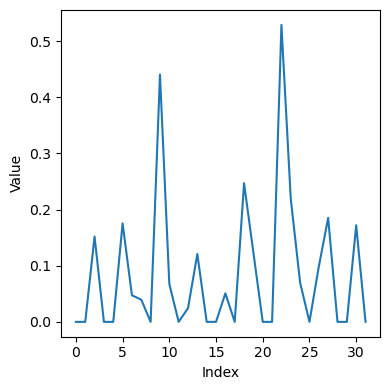

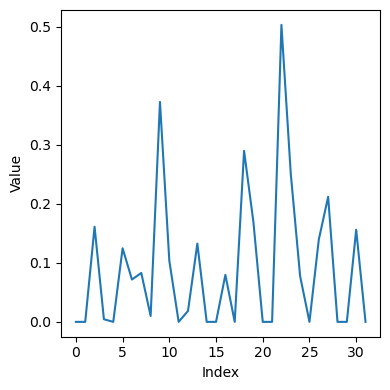

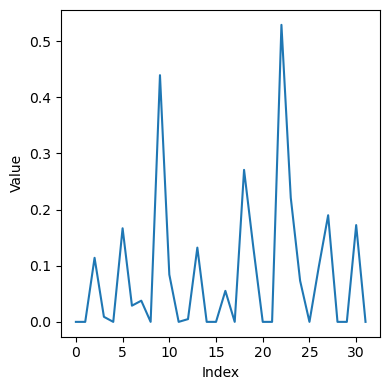

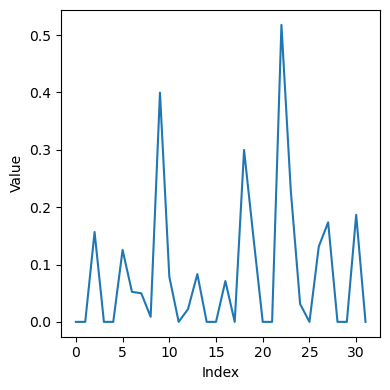

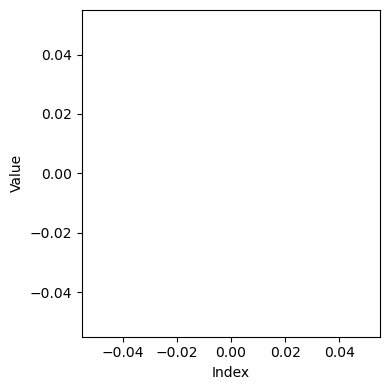

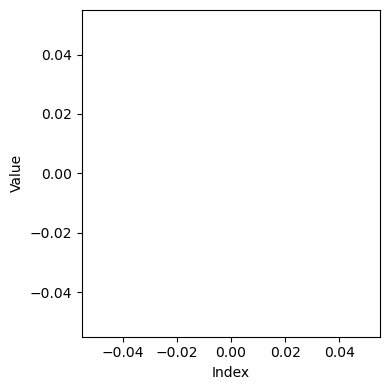

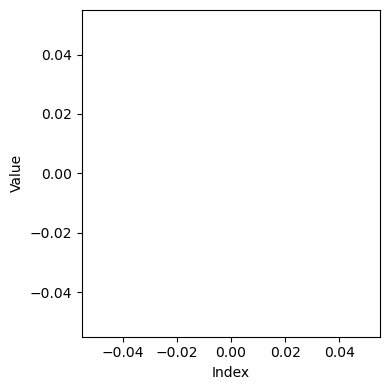

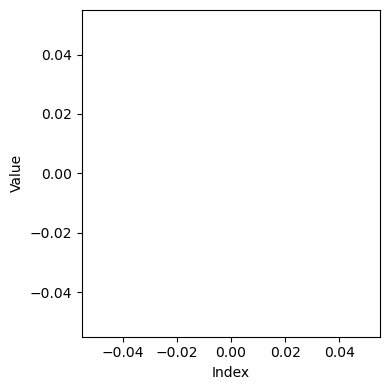

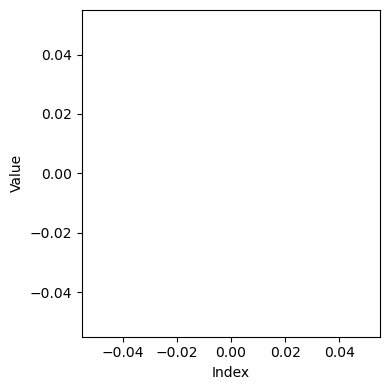

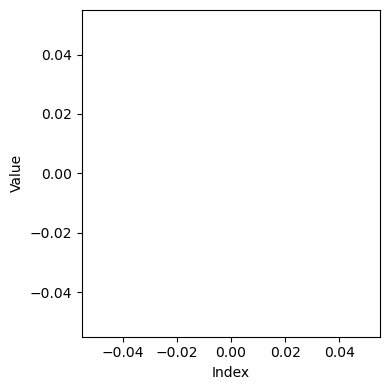

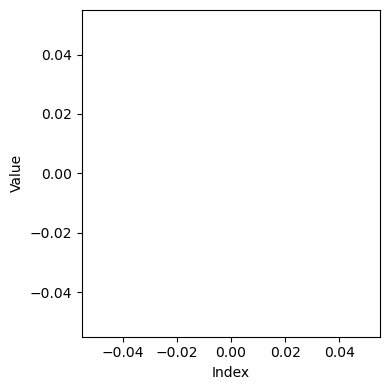

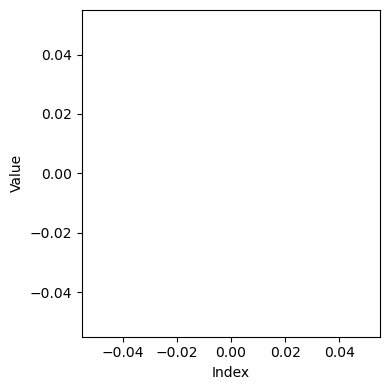

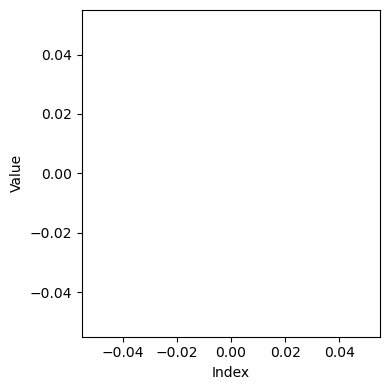

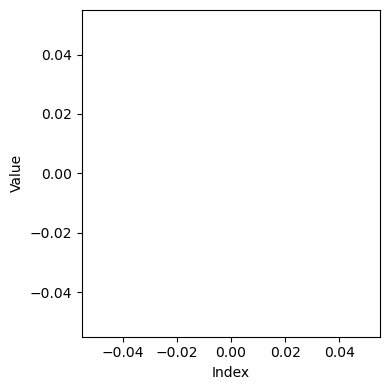

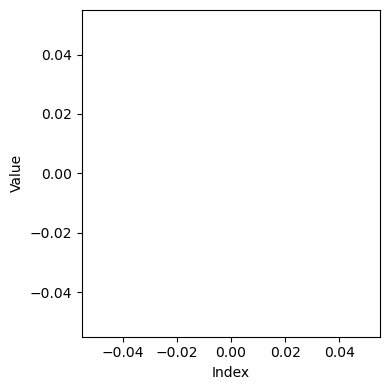

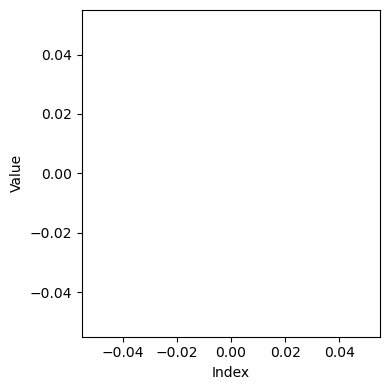

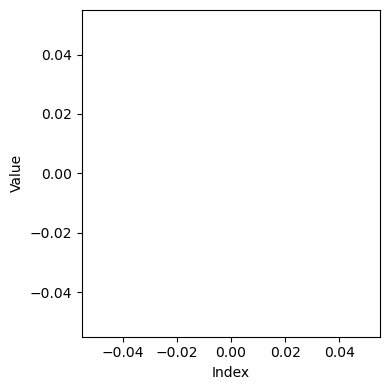

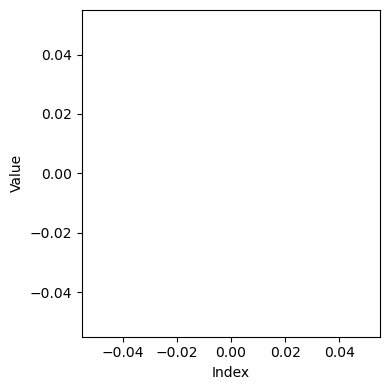

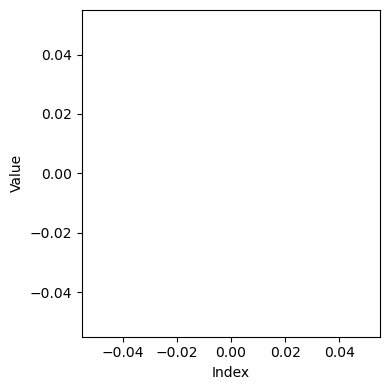

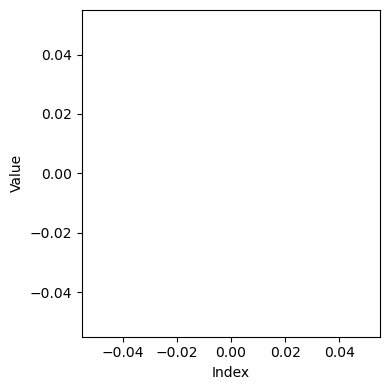

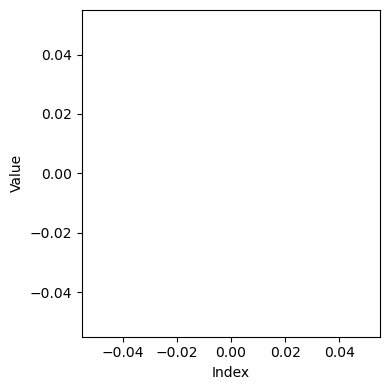

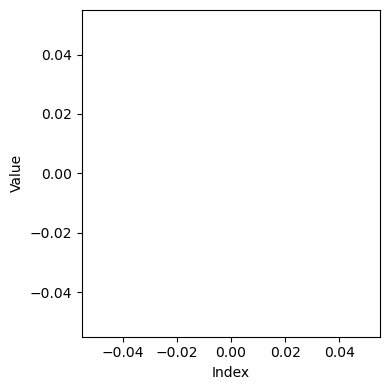

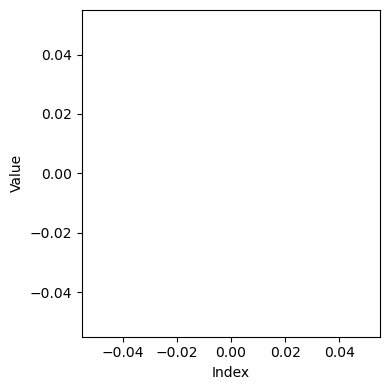

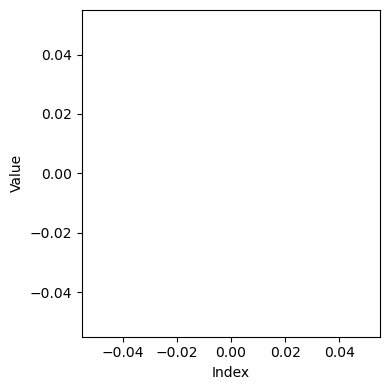

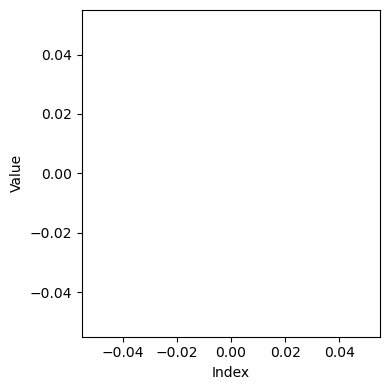

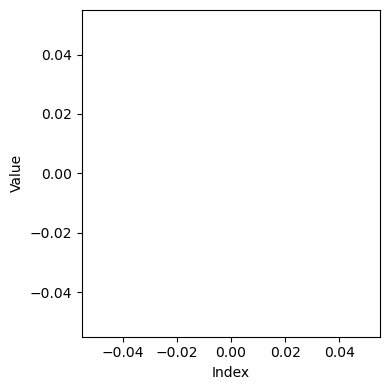

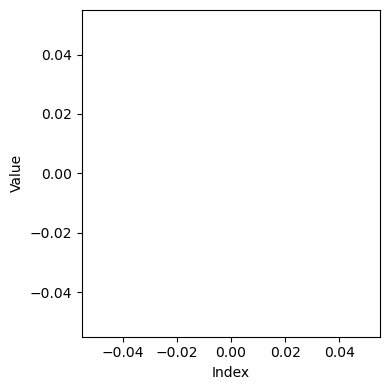

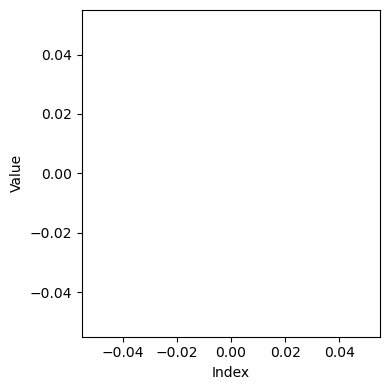

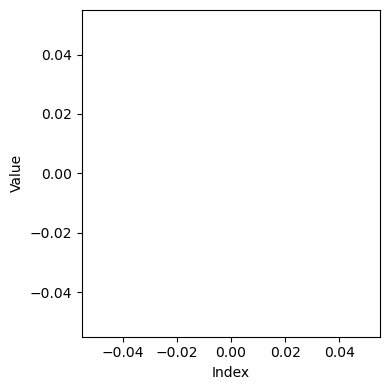

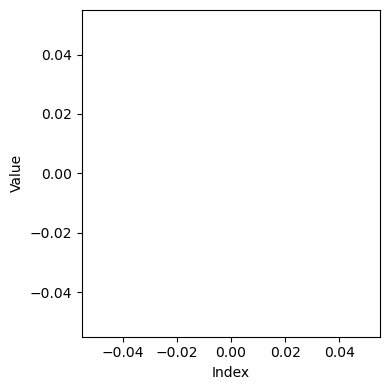

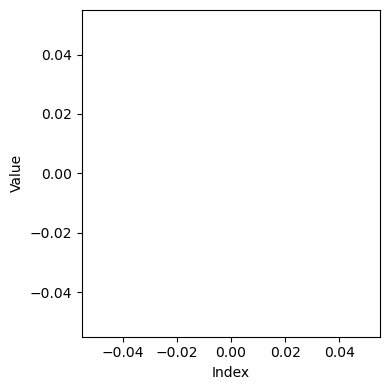

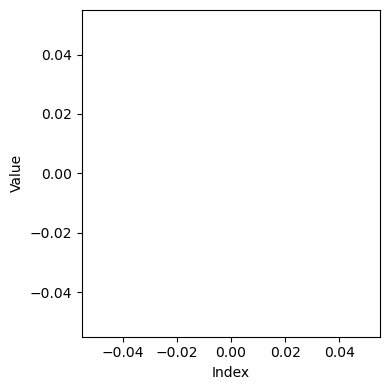

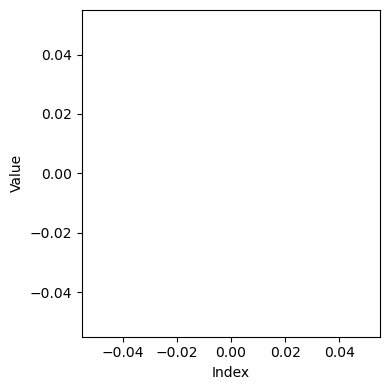

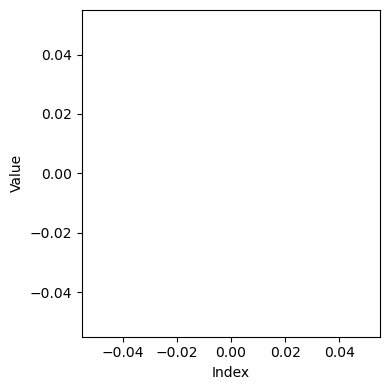

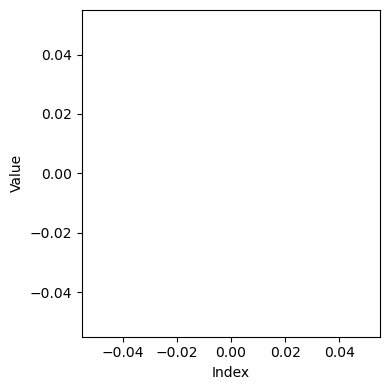

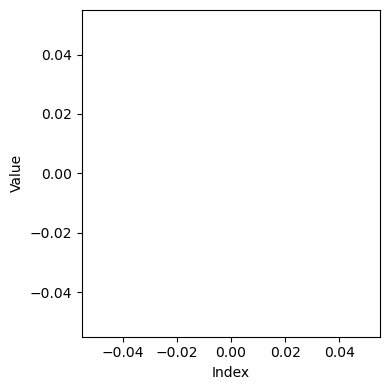

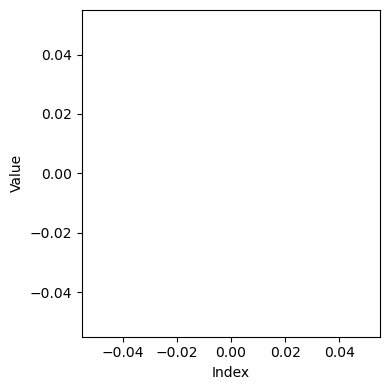

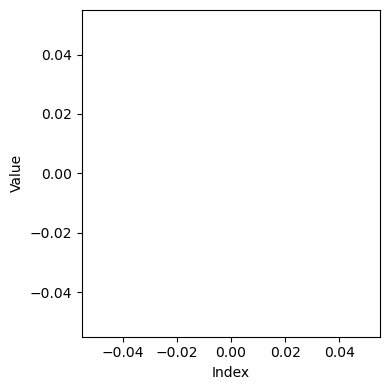

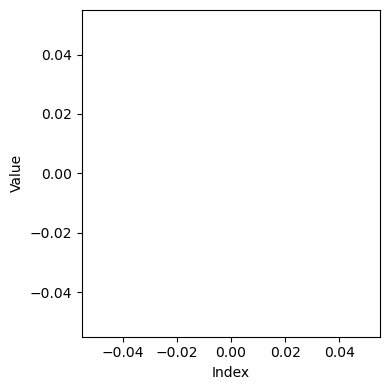

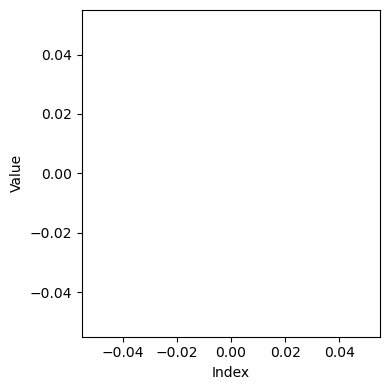

In [97]:

for i in range(40):
    fig, ax1 = plt.subplots(1, figsize=(4, 4))
    ax1.plot(range(32), multi_scale_feature_mapping_output[0, :, i].cpu().detach().numpy())
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Value')

    plt.tight_layout()
    plt.show()

# 2. Linear Layer